In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# @title Figure settings
import ipywidgets as widgets  # interactive display
from ipywidgets import fixed
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [3]:
# @title Plotting functions
import numpy
from numpy.linalg import inv, eig
from math import ceil
from matplotlib import pyplot, ticker, get_backend, rc
from mpl_toolkits.mplot3d import Axes3D
from itertools import cycle

_int_backends = ['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg',
                 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo',
                 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo']
_backend = get_backend()   # get current backend name

# shrink figsize and fontsize when using %matplotlib notebook
if _backend in _int_backends:
  fontsize = 4
  fig_scale = 0.75
else:
  fontsize = 5
  fig_scale = 1

grey = '#808080'
gold = '#cab18c'        # x-axis grid
lightblue = '#0096d6'   # y-axis grid
green = '#008367'       # x-axis basis vector
red = '#E31937'         # y-axis basis vector
darkblue = '#004065'

pink, yellow, orange, purple, brown = '#ef7b9d', '#fbd349', '#ffa500', '#a35cff', '#731d1d'

quiver_params = {'angles': 'xy',
                 'scale_units': 'xy',
                 'scale': 1,
                 'width': 0.012}

grid_params = {'linewidth': 0.5,
               'alpha': 0.8}

def set_rc(func):
  def wrapper(*args, **kwargs):
    rc('font', family='serif', size=fontsize)
    rc('figure', dpi=200)
    rc('axes', axisbelow=True, titlesize=5)
    rc('lines', linewidth=1)
    func(*args, **kwargs)
  return wrapper

@set_rc
def plot_vector(vectors, tails=None):
  ''' Draw 2d vectors based on the values of the vectors and the position of their tails.

  Parameters
  ----------
  vectors : list.
    List of 2-element array-like structures, each represents a 2d vector.

  tails : list, optional.
    List of 2-element array-like structures, each represents the coordinates of the tail
    of the corresponding vector in vectors. If None (default), all tails are set at the
    origin (0,0). If len(tails) is 1, all tails are set at the same position. Otherwise,
    vectors and tails must have the same length.

  Examples
  --------
  >>> v = [(1, 3), (3, 3), (4, 6)]
  >>> plot_vector(v)      # draw 3 vectors with their tails at origin
  >>> t = [numpy.array((2, 2))]
  >>> plot_vector(v, t)   # draw 3 vectors with their tails at (2,2)
  >>> t = [[3, 2], [-1, -2], [3, 5]]
  >>> plot_vector(v, t)   # draw 3 vectors with 3 different tails

  '''
  vectors = numpy.array(vectors)
  assert vectors.shape[1] == 2, "Each vector should have 2 elements."
  if tails is not None:
    tails = numpy.array(tails)
    assert tails.shape[1] == 2, "Each tail should have 2 elements."
  else:
    tails = numpy.zeros_like(vectors)

  # tile vectors or tails array if needed
  nvectors = vectors.shape[0]
  ntails = tails.shape[0]
  if nvectors == 1 and ntails > 1:
    vectors = numpy.tile(vectors, (ntails, 1))
  elif ntails == 1 and nvectors > 1:
    tails = numpy.tile(tails, (nvectors, 1))
  else:
    assert tails.shape == vectors.shape, "vectors and tail must have a same shape"

  # calculate xlimit & ylimit
  heads = tails + vectors
  limit = numpy.max(numpy.abs(numpy.hstack((tails, heads))))
  limit = numpy.ceil(limit * 1.2)   # add some margins

  figsize = numpy.array([2,2]) * fig_scale
  figure, axis = pyplot.subplots(figsize=figsize)
  axis.quiver(tails[:,0], tails[:,1], vectors[:,0], vectors[:,1], color=darkblue,
                  angles='xy', scale_units='xy', scale=1)
  axis.set_xlim([-limit, limit])
  axis.set_ylim([-limit, limit])
  axis.set_aspect('equal')

  # if xticks and yticks of grid do not match, choose the finer one
  xticks = axis.get_xticks()
  yticks = axis.get_yticks()
  dx = xticks[1] - xticks[0]
  dy = yticks[1] - yticks[0]
  base = max(int(min(dx, dy)), 1)   # grid interval is always an integer
  loc = ticker.MultipleLocator(base=base)
  axis.xaxis.set_major_locator(loc)
  axis.yaxis.set_major_locator(loc)
  axis.grid(True, **grid_params)

  # show x-y axis in the center, hide frames
  axis.spines['left'].set_position('center')
  axis.spines['bottom'].set_position('center')
  axis.spines['right'].set_color('none')
  axis.spines['top'].set_color('none')

@set_rc
def plot_transformation_helper(axis, matrix, *vectors, unit_vector=True, unit_circle=False, title=None):
  """ A helper function to plot the linear transformation defined by a 2x2 matrix.

  Parameters
  ----------
  axis : class matplotlib.axes.Axes.
    The axes to plot on.

  matrix : class numpy.ndarray.
    The 2x2 matrix to visualize.

  *vectors : class numpy.ndarray.
    The vector(s) to plot along with the linear transformation. Each array denotes a vector's
    coordinates before the transformation and must have a shape of (2,). Accept any number of vectors.

  unit_vector : bool, optional.
    Whether to plot unit vectors of the standard basis, default to True.

  unit_circle: bool, optional.
    Whether to plot unit circle, default to False.

  title: str, optional.
    Title of the plot.

  """
  assert matrix.shape == (2,2), "the input matrix must have a shape of (2,2)"
  grid_range = 20
  x = numpy.arange(-grid_range, grid_range+1)
  X_, Y_ = numpy.meshgrid(x,x)
  I = matrix[:,0]
  J = matrix[:,1]
  X = I[0]*X_ + J[0]*Y_
  Y = I[1]*X_ + J[1]*Y_
  origin = numpy.zeros(1)

  # draw grid lines
  for i in range(x.size):
    axis.plot(X[i,:], Y[i,:], c=gold, **grid_params)
    axis.plot(X[:,i], Y[:,i], c=lightblue, **grid_params)

  # draw (transformed) unit vectors
  if unit_vector:
    axis.quiver(origin, origin, [I[0]], [I[1]], color=green, **quiver_params)
    axis.quiver(origin, origin, [J[0]], [J[1]], color=red, **quiver_params)

  # draw optional vectors
  color_cycle = cycle([pink, darkblue, orange, purple, brown])
  if vectors:
    for vector in vectors:
      color = next(color_cycle)
      vector_ = matrix @ vector.reshape(-1,1)
      axis.quiver(origin, origin, [vector_[0]], [vector_[1]], color=color, **quiver_params)

  # draw optional unit circle
  if unit_circle:
    alpha =  numpy.linspace(0, 2*numpy.pi, 41)
    circle = numpy.vstack((numpy.cos(alpha), numpy.sin(alpha)))
    circle_trans = matrix @ circle
    axis.plot(circle_trans[0], circle_trans[1], color=red, lw=0.8)

  # hide frames, set xlimit & ylimit, set title
  limit = 4
  axis.spines['left'].set_position('center')
  axis.spines['bottom'].set_position('center')
  axis.spines['left'].set_linewidth(0.3)
  axis.spines['bottom'].set_linewidth(0.3)
  axis.spines['right'].set_color('none')
  axis.spines['top'].set_color('none')
  axis.set_xlim([-limit, limit])
  axis.set_ylim([-limit, limit])
  if title is not None:
    axis.set_title(title)

@set_rc
def plot_linear_transformation(matrix, *vectors, name = None, unit_vector=True, unit_circle=False):
  """ Plot the linear transformation defined by a 2x2 matrix using the helper
  function plot_transformation_helper(). It will create 2 subplots to visualize some
  vectors before and after the transformation.

  Parameters
  ----------
  matrix : class numpy.ndarray.
    The 2x2 matrix to visualize.

  *vectors : class numpy.ndarray.
    The vector(s) to plot along with the linear transformation. Each array denotes a vector's
    coordinates before the transformation and must have a shape of (2,). Accept any number of vectors.

  unit_vector : bool, optional.
    Whether to plot unit vectors of the standard basis, default to True.

  unit_circle: bool, optional.
    Whether to plot unit circle, default to False.

  """
  figsize = numpy.array([4,2]) * fig_scale
  figure, (axis1, axis2) = pyplot.subplots(1, 2, figsize=figsize)
  plot_transformation_helper(axis1, numpy.identity(2), *vectors, unit_vector=unit_vector, unit_circle=unit_circle, title='Before transformation')
  plot_transformation_helper(axis2, matrix, *vectors, unit_vector=unit_vector, unit_circle=unit_circle, title='After transformation')
  if name is not None:
    figure.suptitle(f'Population {name}')


def plot_eig_vec_transform(W):
  classic = 'k'
  vec_names = ['a', 'b','c','d','e','f','g', 'h']

  _, vecs = np.linalg.eig(W)
  vecs = vecs.T

  fig, axes = plt.subplots(1, 2, figsize=(2, 1))
  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

  for i in range(2):
    axes[i].set(xlim=[-3.5, 3.5], ylim=[-3.5,3.5])
    axes[i].axis('Off')
    axes[i].plot([0, 0], [-3.5, 3.5], classic, alpha=.4)
    axes[i].plot([-3.5, 3.5], [0, 0], classic, alpha=.4)

  for i_vec, vec in enumerate(vecs):
    axes[0].arrow(0, 0, vec[0], vec[1], head_width=.2, facecolor=colors[i_vec], edgecolor=colors[i_vec], length_includes_head=True)
    axes[0].annotate(vec_names[i_vec], xy=(vec[0]+np.sign(vec[0])*.15, vec[1]+np.sign(vec[1])*.15), color=colors[i_vec])

    transformed_vec = np.matmul(W, vec)
    axes[1].arrow(0, 0, transformed_vec[0], transformed_vec[1], head_width=.2, facecolor=colors[i_vec], edgecolor=colors[i_vec], length_includes_head=True)
    axes[1].annotate(vec_names[i_vec], xy=(transformed_vec[0]+np.sign(transformed_vec[0])*.15, transformed_vec[1]+np.sign(transformed_vec[1])*.15), color=colors[i_vec])

  axes[0].set_title('Before')
  axes[1].set_title('After')

# Section 1 : Intro to matrices
## Section 1.1 : Matrices to solve systems of equations

### Understanding neural transformations

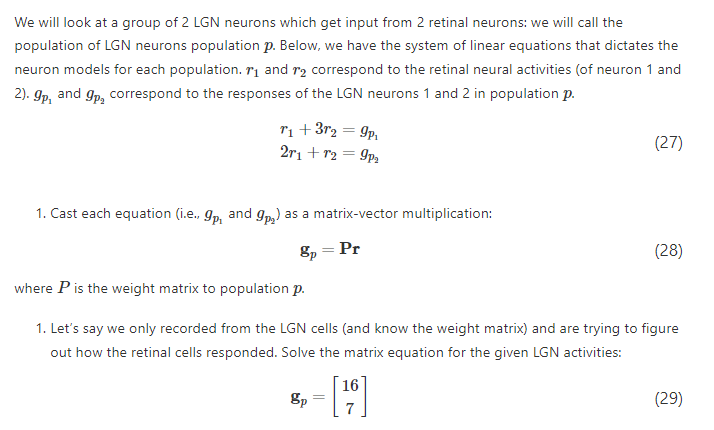

In [12]:
# Create P (using np array)
P = np.array([[1,3],[2,1]])

# Create g_p (using np array)
g_p = np.array([16, 7])

# Solve for r (using np.linalg.inv)
r = np.linalg.inv(P)@g_p

# Print r
print(r)

[1. 5.]


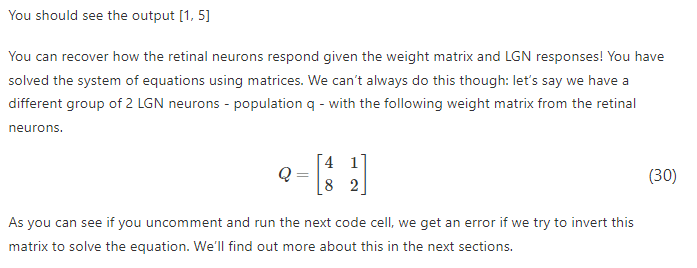

In [14]:
g_q = np.array([16, 7])
Q = np.array([[4, 1], [8, 2]])

print(np.linalg.inv(Q) @ g_q)

LinAlgError: Singular matrix

## Section 1.2: Matrices as linear transformations

### Creating matrices for transformations

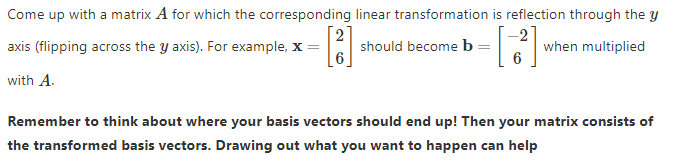

[-2  6]


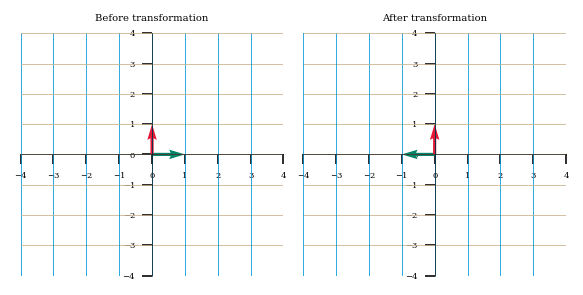

In [18]:
A = np.array([[-1,0],[0,1]])
x = np.array([2,6])
b=A@x
print(b)
# Uncomment to visualize transformation
plot_linear_transformation(A)

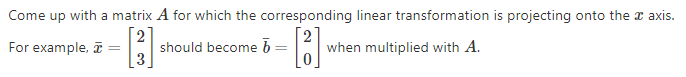

[2 0]


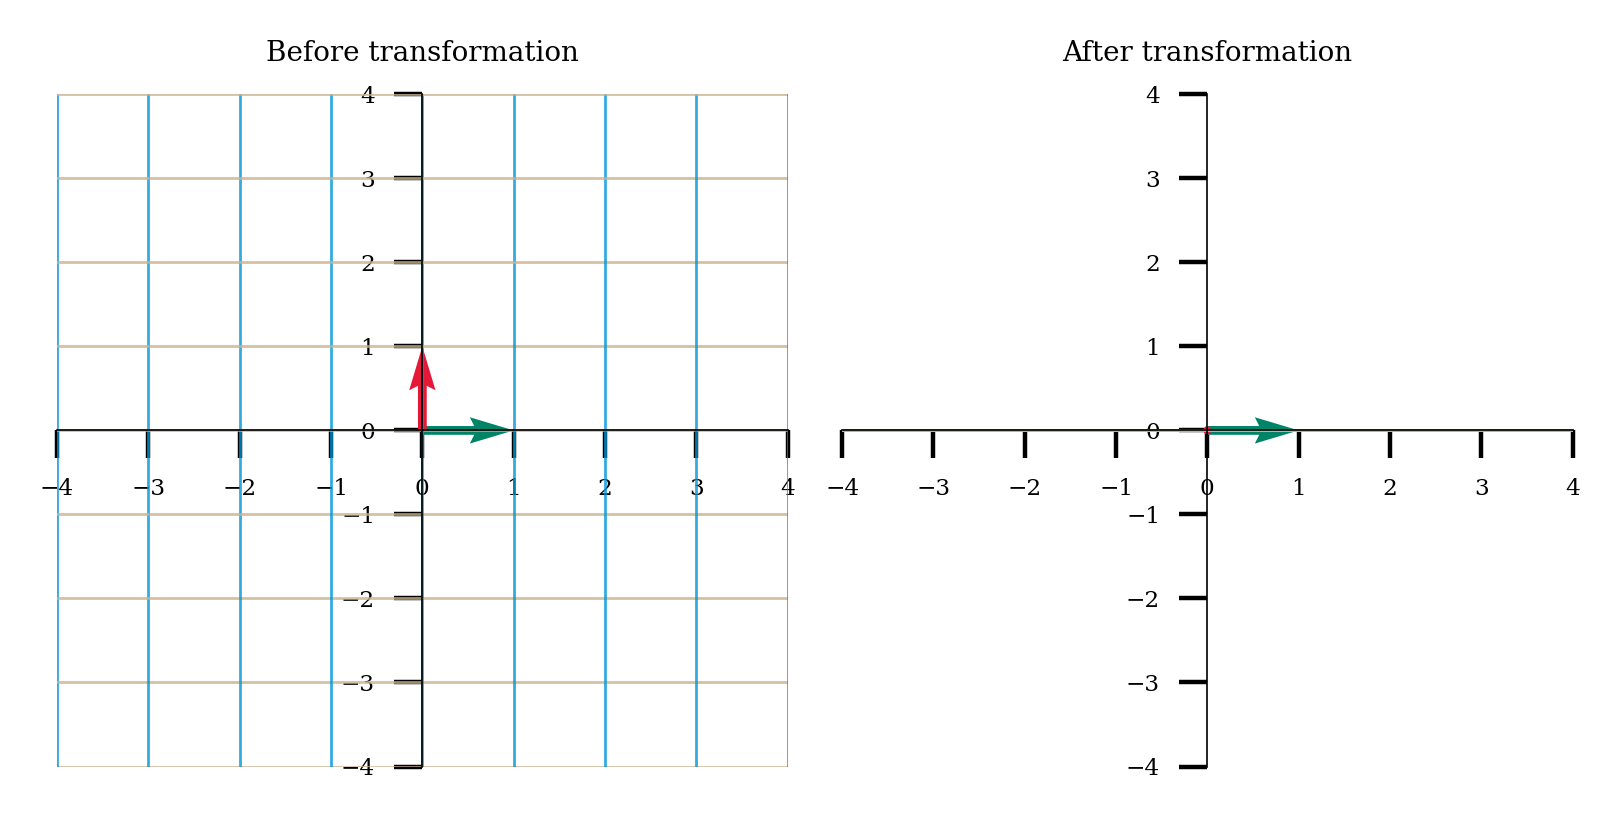

In [22]:
A = np.array([[1,0],[0,0]])
x = np.array([2,3])
b=A@x
# Uncomment to visualize transformation
print(b)
plot_linear_transformation(A)

## Section 1.3 : Rank & Null space
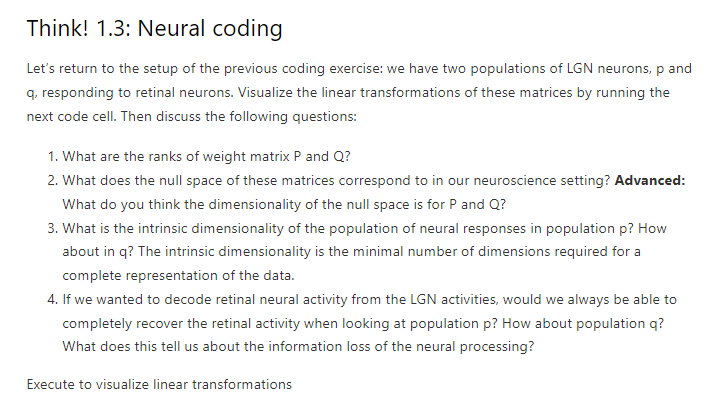


1)  P is transforming from all of 2D space to all of 2D space. The range of P is
    all of 2D space so the rank is 2. Q is squishing space from 2D to a 1D line.
    The range of Q is that 1D line so the rank is 1.
    
2)  The null space is the patterns of retinal activity that result in 0 firing for the
    LGN neurons. The dimensionality of the null space of P is 0 (only the origin would
    be mapped to the origin). The dimensionality of the null space of Q is 1: when we
    squish 2D space onto the 1D line, a full 1D line would be squished onto the origin.
    
3)  The intrinsic dimensionality of the responses of neurons in population p is 2
    (the possible response pairs span all of 2D space). For population q, the intrinsic dimensionality
    is 1: the possible response pairs lie along a 1D line. These neural responses could be fully described by just
    1 number if we switched to a basis for that line.
    
4)  We could completely recover the retinal neural activity given the LGN activities in population
    p as the matrix P is full rank and invertible. There is no information loss from the
    two retinal neurons to the two LGN neurons. We cannot recover retinal activity given population
    q since we lose a dimension. There is information loss between retinal neurons and population q
    LGN neurons.


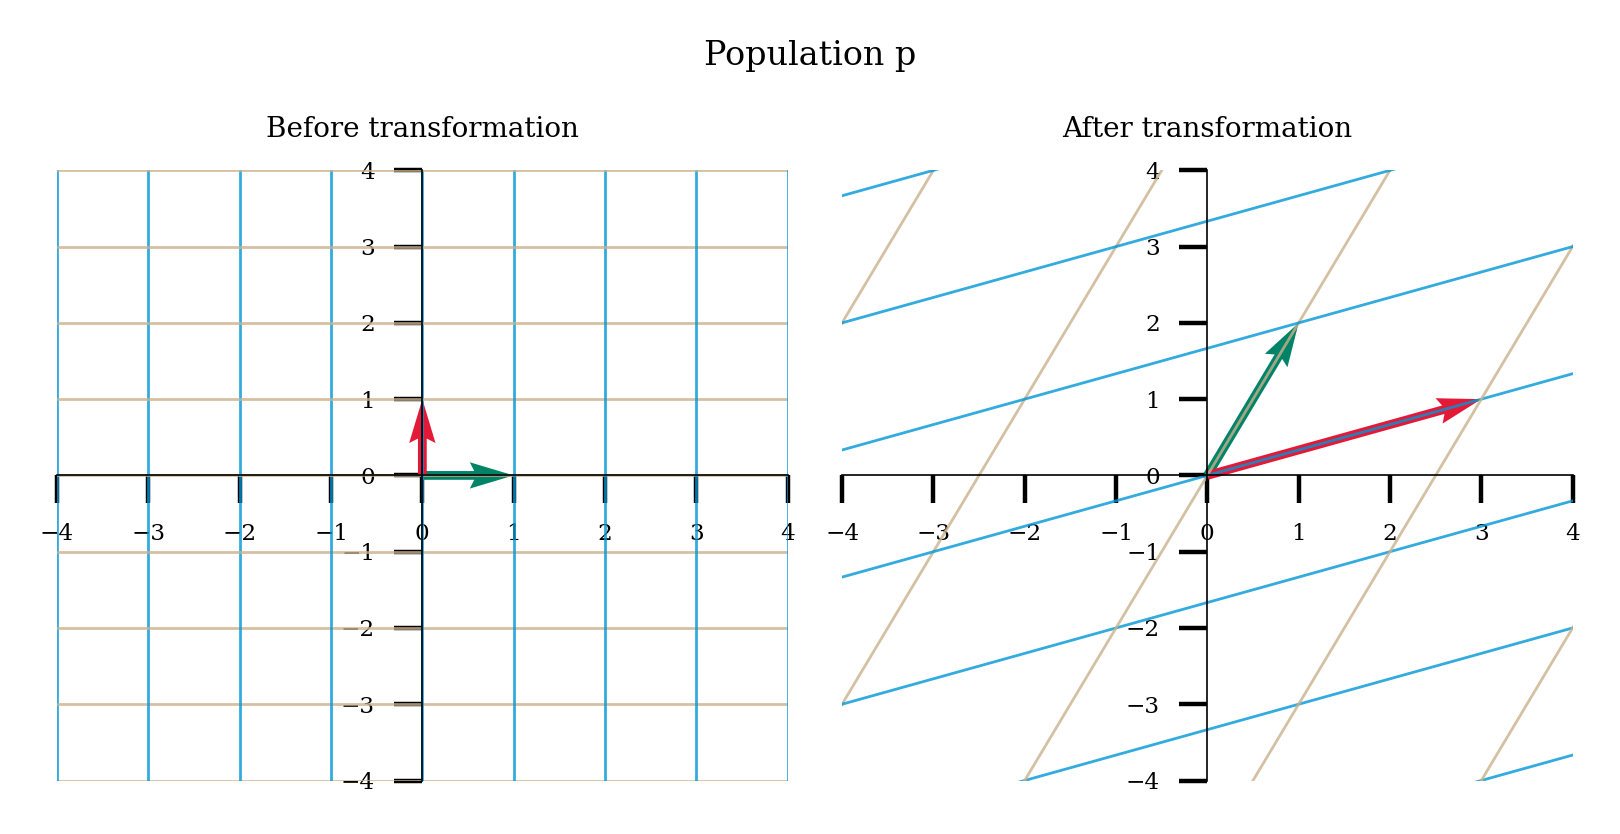

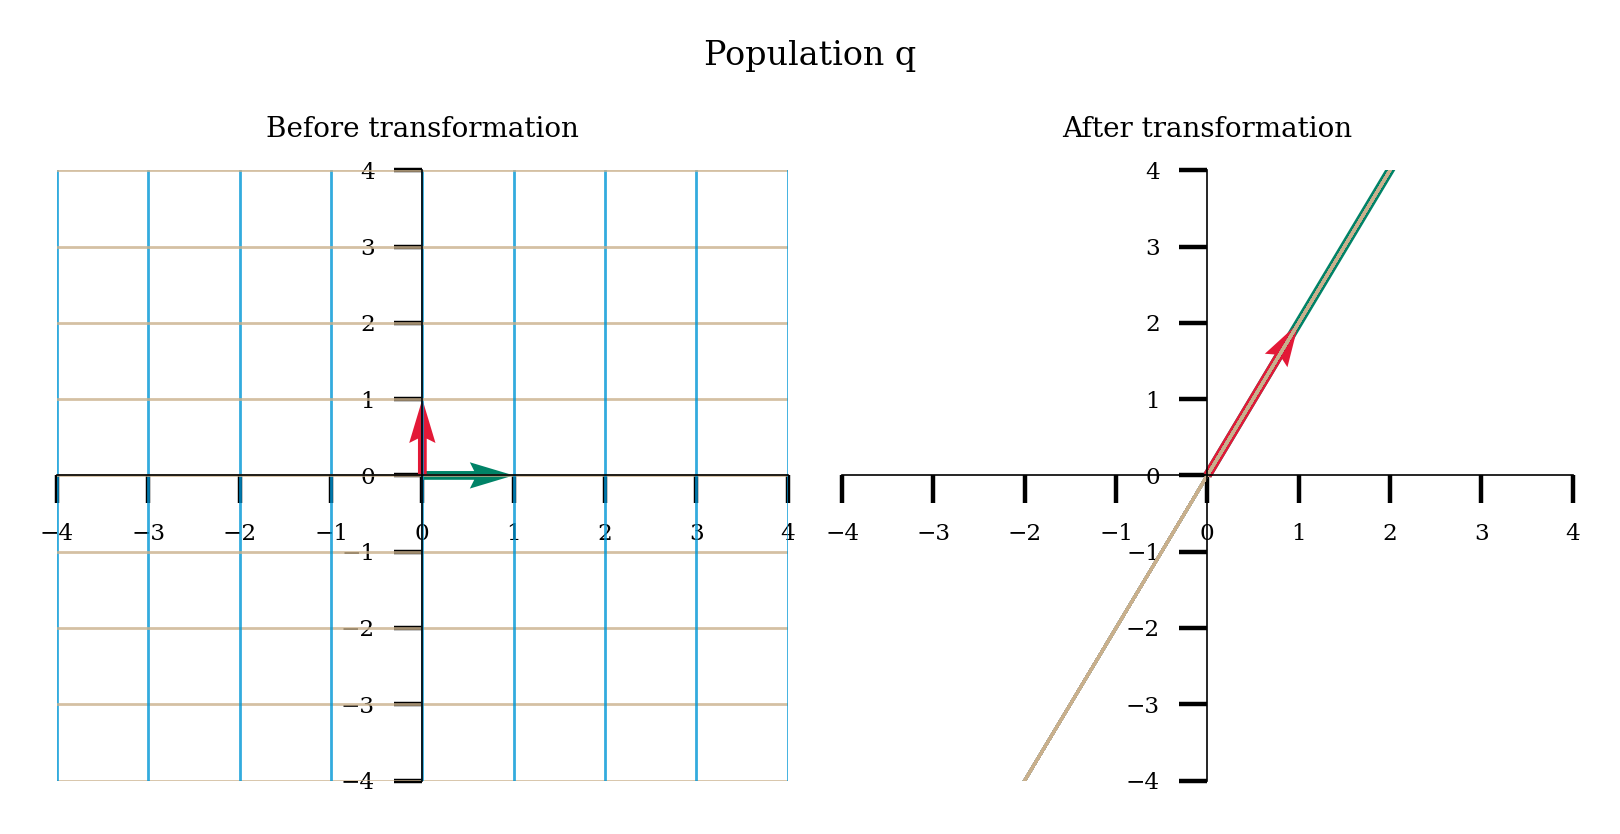

In [23]:
# @markdown Execute to visualize linear transformations
P = np.array([[1, 3], [2, 1]])
plot_linear_transformation(P, name = 'p')

Q = np.array([[4, 1], [8, 2]])
plot_linear_transformation(Q, name = 'q')

# Section 2 : Eigenvalues & Eigenvectors
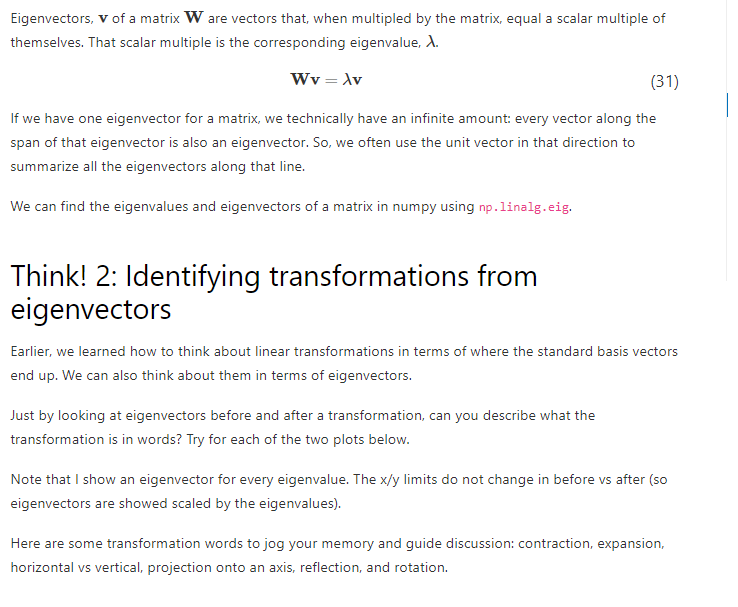

1)  The first transformation is a horizontal expansion. You can see that b doesn't
    change length, while a grows longer. Since these eigenvectors are aligned
    with the axes, we know that there is no movement in the vertical direction
    (based on b) and an expansion in the horizontal direction (based on a).
    
2)  This transformation is a reflection over the line y = x. Neither eigenvector
    changes length, a is along the line y = x and b is flipped over it.

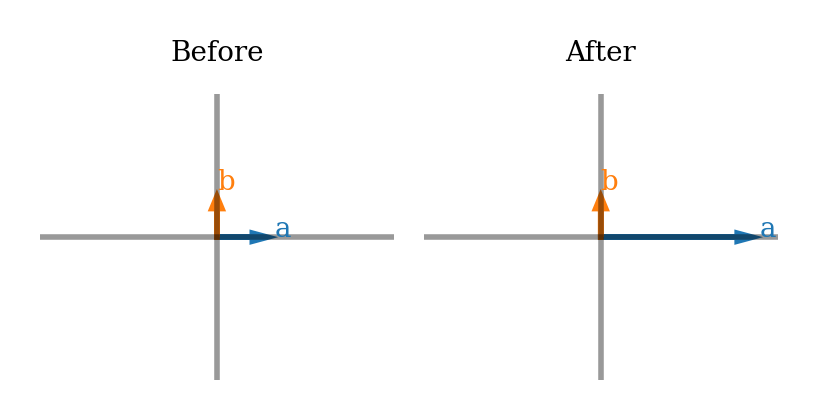

In [24]:
W = np.array([[3, 0], [0, 1]])
plot_eig_vec_transform(W)

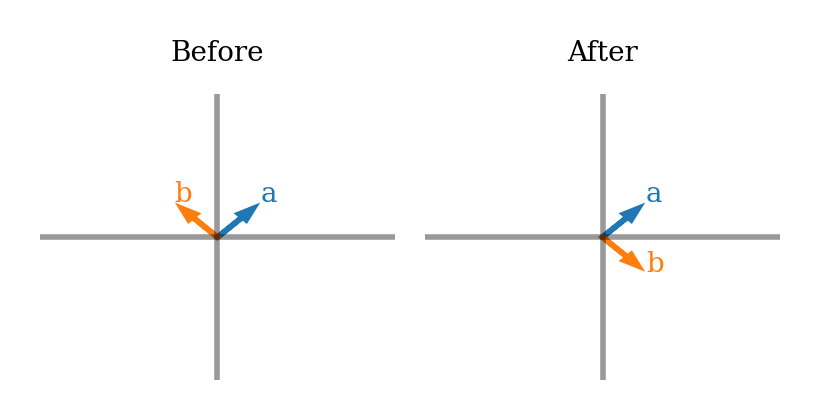

In [25]:
W = np.array([[0, 1], [1, 0]])
plot_eig_vec_transform(W)

# Matrix multiplication
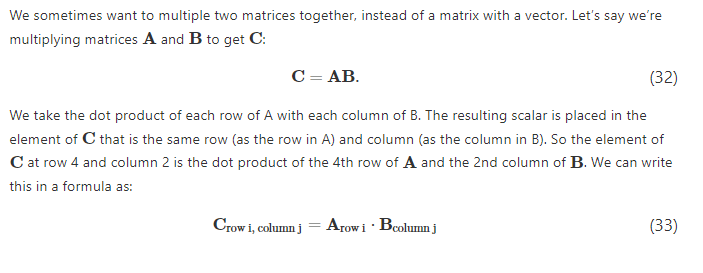

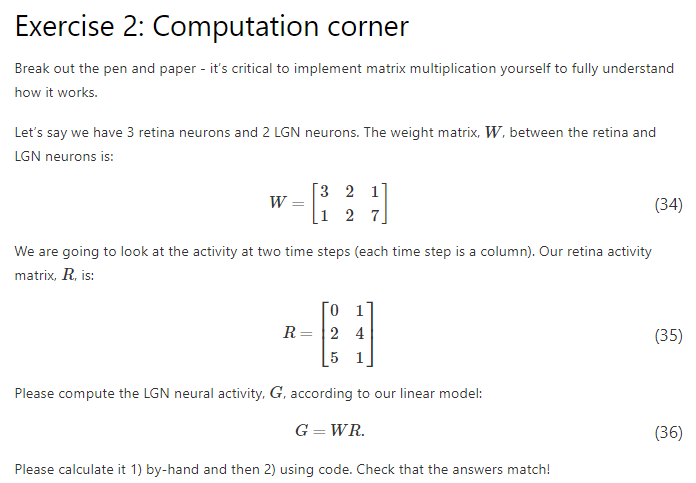

In [26]:
# Define R
R = np.array([[0,1],[2,4],[5,1]])

# Define W
W = np.array([[3,2,1],[1,2,7]])

# Compute G
# in Python, we can use @ for matrix multiplication: matrix1 @ matrix2
G = W@R

# Print values of G
print(G)

[[ 9 12]
 [39 16]]
